In [3]:
import pandas as pd
import numpy as np
from fbprophet import Prophet

import pandas as pd
import datetime as dt

from scipy import stats
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
%matplotlib inline
import calendar

## Читаем данные

In [106]:
df=pd.read_pickle('MG_Sales.pickle',compression='gzip')

## Обучение с помощью прорицателя фейсбука

In [107]:
#Параметры:  (-11, 4, 0.08531678524172806, 90, 5)
#Праздники
changepoint_prior_scale=0.08531678524172806
seasonality_prior_scale=90
holidays_prior_scale=5

changepoints=df[df['Праздник']==1]['Дата'].unique()
selebrate=pd.DataFrame({
    'holiday': 'holiday',
    'ds': changepoints,
    'lower_window': -11,
    'upper_window': 4,
    })

changepoints=changepoints


#Формируем выборку
time_series=pd.DataFrame(data=df[df['Дата']>=dt.date(2015,1,1)].groupby('Дата')['Количество'].sum())
time_series.index.name='ds'
time_series.columns=['y']
time_series['y'] = np.log(time_series['y'])

#выборка обратная дифференцированию
diff=time_series[:time_series.iloc[365].name-dt.timedelta(days=1)].reset_index()
diff['ds']=diff['ds'].map(lambda date: date + pd.DateOffset(years=2))#добавляем нужное количество лет
diff['yhat']=diff['y']
diff.set_index('ds', inplace=True)

#time_series=time_series.diff(7).dropna()#дифференцируем ряд
#time_series=time_series.diff(358).dropna()#дифференцируем ряд

## Удаляем выбросы

In [40]:
lim=0.95
ulim=np.percentile(time_series['y'], 100.-lim)
llim=np.percentile(time_series['y'], lim)

#time_series.loc[time_series.y<llim]=None
#time_series.loc[time_series.y>ulim]=None

## Проверка на стационарность

p-value:  0.0748922210892
НЕТ. есть единичные корни, ряд не стационарен
y    4.553877
Name: 2015-01-01 00:00:00, dtype: float64


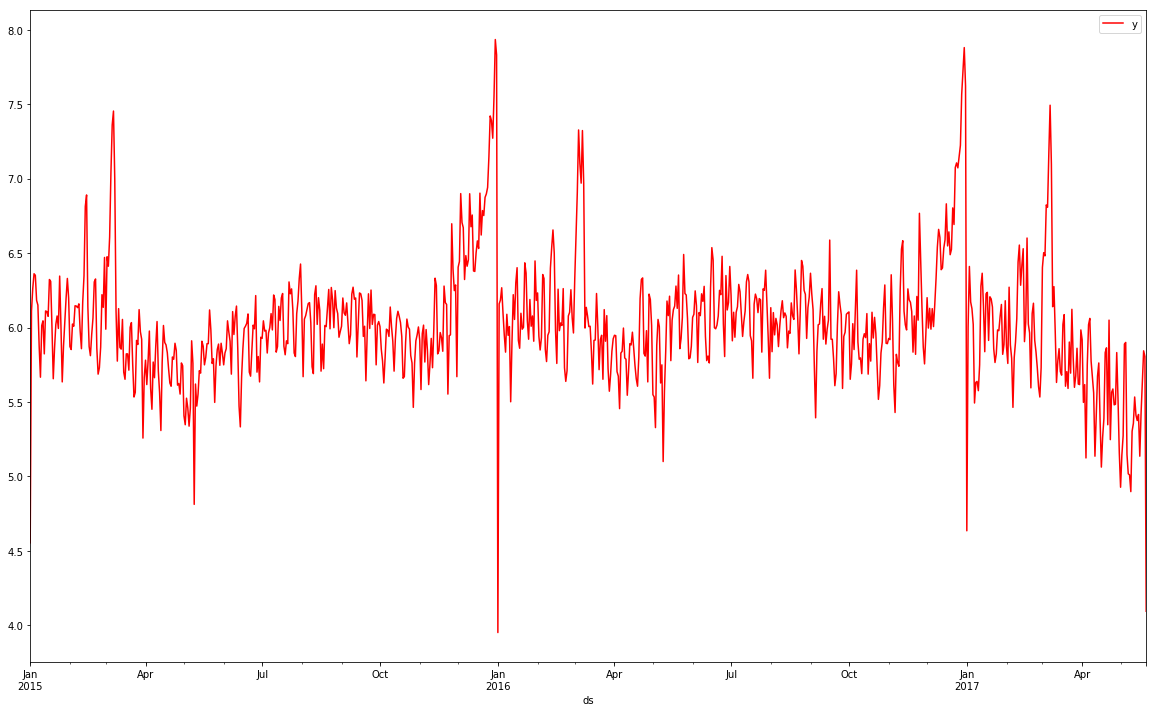

In [108]:
import statsmodels.api as sm


test=sm.tsa.stattools.adfuller(time_series.y)
print ('p-value: ', test[1])
if test[0]> test[4]['5%']: 
    print ('НЕТ. есть единичные корни, ряд не стационарен')
    color='r'
else:
    print ('ДА. единичных корней нет, ряд стационарен')
    color='b'

time_series.plot(figsize=(20,12),color=color) 
print(time_series.iloc[0])

## Обучение выборки с кросс-валидацией

In [109]:
folds=5

#начинаем с последнего месяца
last=time_series.iloc[-1].name
startDt=dt.datetime(last.year,last.month,last.day)
lastDay=dt.datetime(last.year,last.month,1)-dt.timedelta(seconds=1)
startmonth=dt.datetime(lastDay.year,lastDay.month,1)

#готовим период деления валидации
pediods=[]
for i in range(folds):
    pediods.append([startmonth,startDt])    
    startDt=startmonth-dt.timedelta(seconds=1)
    startmonth=dt.datetime(startDt.year,startDt.month,1)

#changepoint_prior_scale - гиперпараметр процента точек смены тренда (по-умолчанию: 0.05)
#changepoints  - массив для ручной установки дат смены тренда
#interval_width - предсказательный интервал
#mcmc_samples - количество шагов для расчета неопределенности в сезонности для байесовской модели
#holidays - датасет с праздникам

#параметр роста
#time_series['cap'] = 150

    
mape=[]
mae=[]
#делим выборку на обучающую и валидационную
for begin,end in reversed(pediods):
    date_div_past=begin-dt.timedelta(days=1)

    time_series_train=time_series.loc[:date_div_past]
    time_series_test=time_series.loc[begin:end]

    m = Prophet(holidays = selebrate,# growth = 'logistic',
                #changepoint_prior_scale=changepoint_prior_scale,
                #seasonality_prior_scale=seasonality_prior_scale,
                #holidays_prior_scale=holidays_prior_scale,
                yearly_seasonality=True)#,mcmc_samples=75
    #обучение
    m.fit(time_series_train.reset_index())
    
    #Подготовка календаря будущего
    future = time_series_test.reset_index()

    #Предсказание
    forecast = m.predict(future)
    
    
    
    cmp_df = forecast.set_index('ds')[['yhat']].join(time_series_test)#np.exp()
    cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
    cmp_df['p'] = 100*cmp_df['e']/cmp_df['y']
    mape.append(round(np.mean(abs(cmp_df['p'])),2))
    mae.append(round(np.mean(abs(cmp_df['e'])),2))    
    
        
print ('Качество модели (%), чем выше тем лучше: ', 100-np.mean(mape))
print ('Абсолютное значение ошибки, чем ниже тем лучше: ', np.mean(mae))

Качество модели (%), чем выше тем лучше:  95.504
Абсолютное значение ошибки, чем ниже тем лучше:  0.266


## Отрисовка от прорицателя

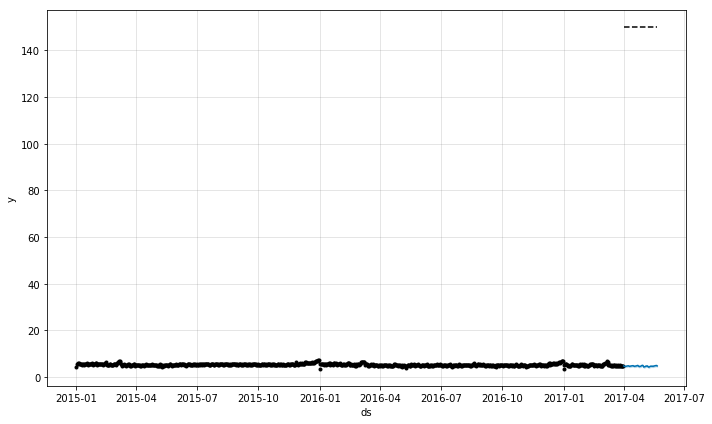

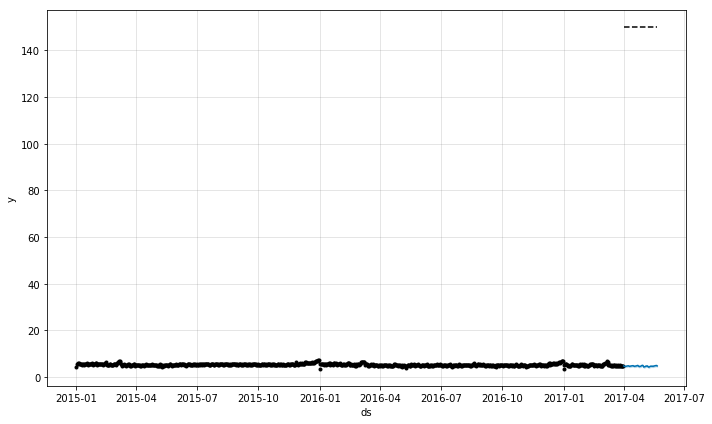

In [6]:
m.plot(forecast)

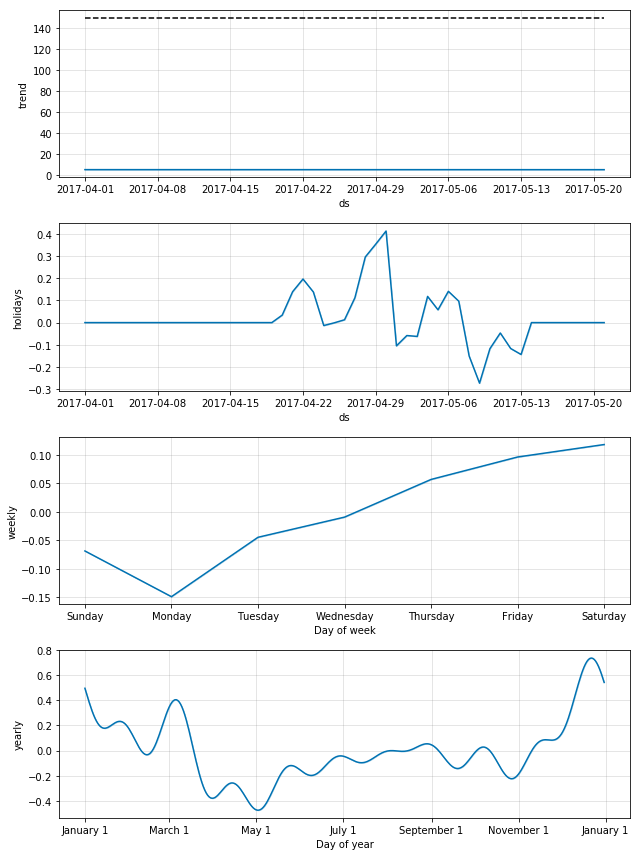

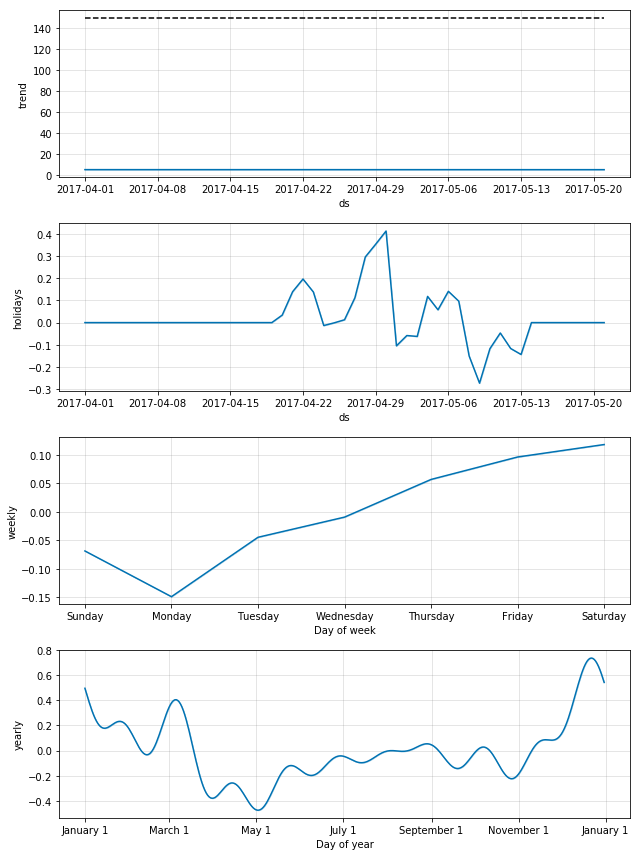

In [7]:
m.plot_components(forecast)

## График прогноза и реальных значений

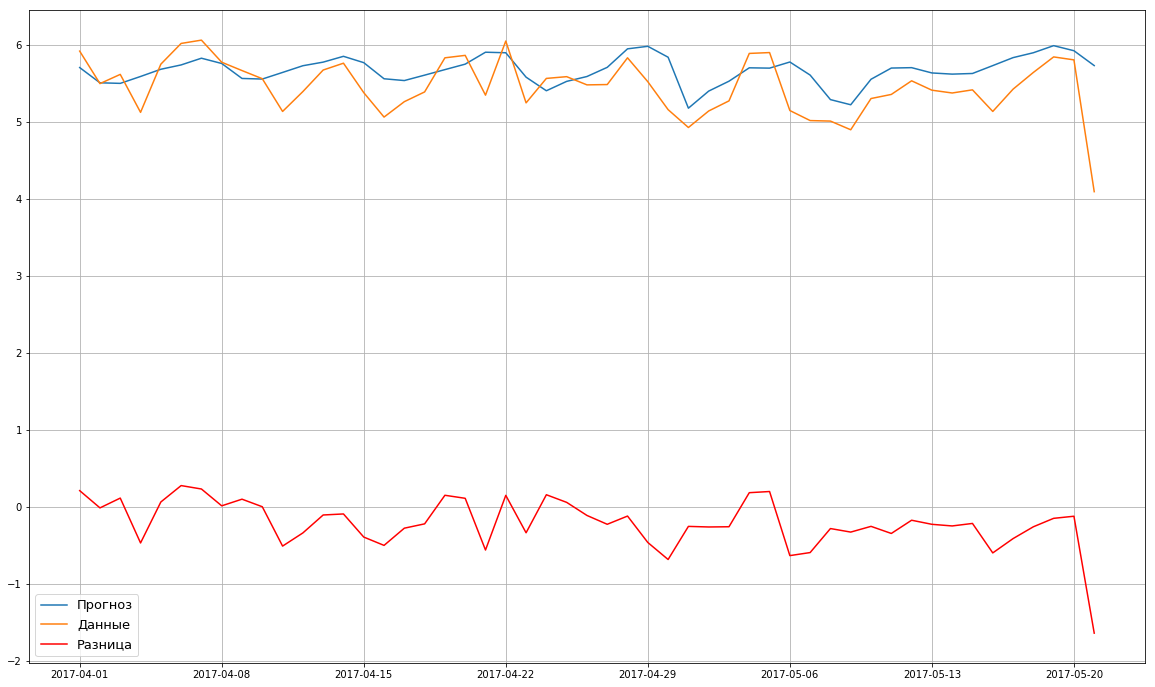

In [110]:
plt.figure(figsize=(20,12))
plt.plot(cmp_df.yhat, label = "Прогноз")
plt.plot(cmp_df.y, label = "Данные")
plt.plot(cmp_df.y-cmp_df.yhat, color='r', label = "Разница")

#plt.axvspan(len(data)-128, len(data), alpha=0.5, color='lightgrey')
plt.grid(True)
plt.axis('tight')
plt.legend(loc="best", fontsize=13);

In [89]:
diff['y']

ds
2017-01-01    4.553877
2017-01-02    6.111467
2017-01-03    6.263398
2017-01-04    6.361302
2017-01-05    6.350886
2017-01-06    6.182085
2017-01-07    6.150603
2017-01-08    5.874931
2017-01-09    5.666427
2017-01-10    6.013715
2017-01-11    6.045005
2017-01-12    5.823046
2017-01-13    6.111467
2017-01-14    6.107023
2017-01-15    6.075346
2017-01-16    6.322565
2017-01-17    6.309918
2017-01-18    6.001415
2017-01-19    5.655992
2017-01-20    5.860786
2017-01-21    6.021023
2017-01-22    6.077642
2017-01-23    5.993961
2017-01-24    6.345636
2017-01-25    6.011267
2017-01-26    5.634790
2017-01-27    5.874931
2017-01-28    6.037871
2017-01-29    6.196444
2017-01-30    6.329721
                ...   
2017-12-02    6.444131
2017-12-03    6.899723
2017-12-04    6.705639
2017-12-05    6.670766
2017-12-06    6.322565
2017-12-07    6.483107
2017-12-08    6.411818
2017-12-09    6.455199
2017-12-10    6.898715
2017-12-11    6.677083
2017-12-12    6.755769
2017-12-13    6.380123
2017-12-

In [90]:
time_series.iloc[0]


Timestamp('2016-01-01 00:00:00')

In [27]:
time_series.iloc[365].name

Timestamp('2016-01-01 00:00:00')